In [18]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

In [19]:
pd.set_option('display.max_rows', None)  # Zeilen: Zeige alle
pd.set_option('display.max_columns', None)  # Spalten: Zeige alle

In [59]:
def plot_gridsearch_results(ergebnisframe, class_weight, elevation=20, azimut = 20): # 3D-Plot erstellen
    # filtern auf class-weight-einträge
    df_temp = ergebnisframe[ergebnisframe["param_svc__class_weight"].apply(lambda x: list(x.values())[1] == class_weight)]
    # sortieren
    df_sorted = df_temp.sort_values(by=["param_svc__C", "param_svc__gamma"], ascending=True)
    
    # Werte extrahieren
    C_values = df_sorted['param_svc__C'].values
    gamma_values = df_sorted['param_svc__gamma'].values
    recall_values = df_sorted['mean_test_recall'].values
    precision_values = df_sorted['mean_test_precision'].values

    # Erstellen eines feineren Gitters für den Flächenplot
    C_fine = np.linspace(C_values.min(), C_values.max(), 150)  # 100 Schritte für feineres Gitter
    gamma_fine = np.linspace(gamma_values.min(), gamma_values.max(), 150)
    C_grid, gamma_grid = np.meshgrid(C_fine, gamma_fine)

    # Interpolation der Werte für Recall und Precision
    recall_grid = griddata((C_values, gamma_values), recall_values, (C_grid, gamma_grid), method='linear')
    precision_grid = griddata((C_values, gamma_values), precision_values, (C_grid, gamma_grid), method='linear')

    # 3D-Plot erstellen
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # 3D-Flächenplot mit Färbung basierend auf Precision
    norm = plt.Normalize(vmin=np.nanmin(precision_grid), vmax=np.nanmax(precision_grid))
    surface = ax.plot_surface(C_grid, gamma_grid, recall_grid, facecolors=plt.cm.viridis(norm(precision_grid)), 
                               rstride=1, cstride=1, alpha=0.8, linewidth=0.1, edgecolor='black')

    # Achsentitel hinzufügen
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_zlabel('Recall Strokes auf Testmenge')
    ax.set_title('GridSearch Ergebnisse')

    # Farblegende für Precision
    mappable = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    mappable.set_array([])  # Ein leeres Array, da die Farblegende keine direkten Daten benötigt
    colorbar = fig.colorbar(mappable, ax=ax, shrink=0.5, pad=0.1)  # `ax` explizit setzen
    colorbar.set_label('Precision Strokes auf Testmenge')
    colorbar.ax.tick_params(labelsize=10)

    # Drehwinkel für die Ansicht setzen
    ax.view_init(elev=elevation, azim=azimut)

    # Anzeigen des Plots
    plt.show()

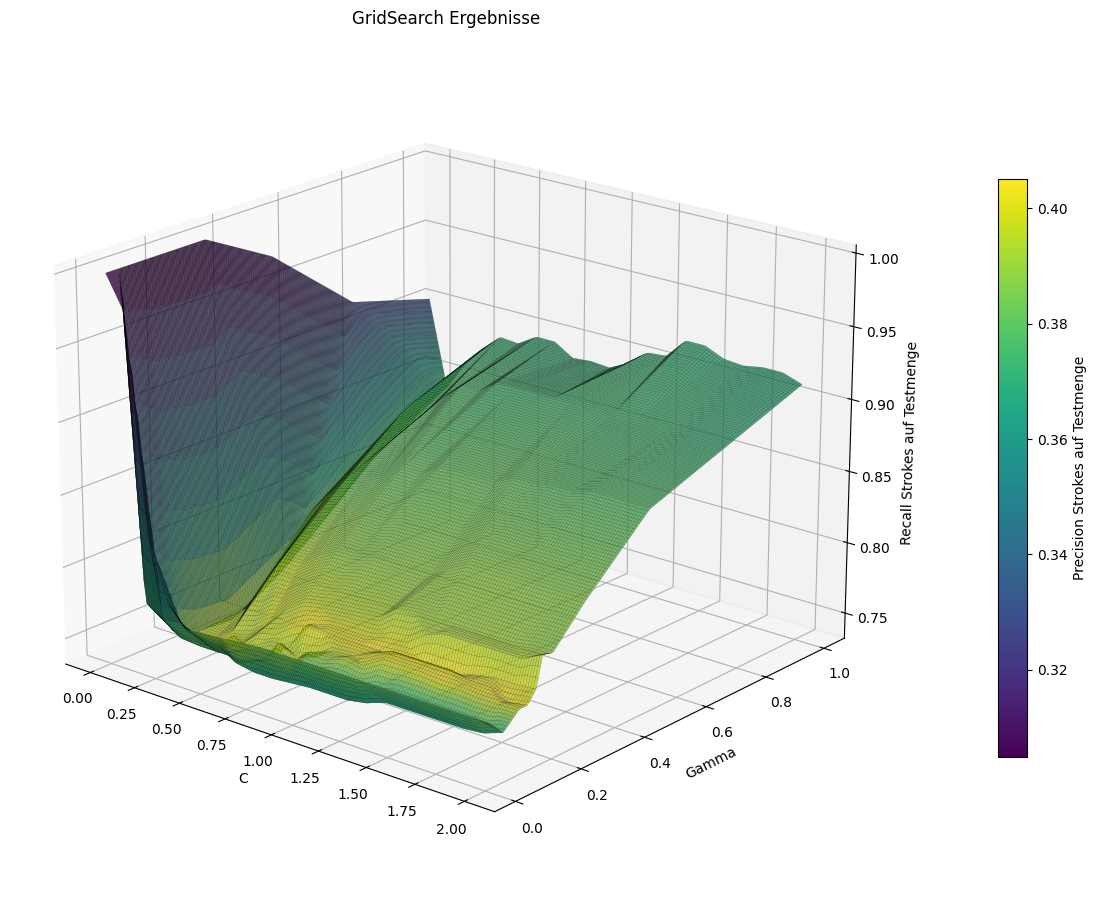

In [110]:
############ welche öffnen? #######
area = "partial_smote_rough_risk_patients"
only_original_columns = 0
if area == "tradeoff":
    open_gridsearch = "gridsearch_tradeoff_final.pkl"
elif area == "underfitting":
    open_gridsearch = "gridsearch_C_and_gamma_close_to_zero.pkl"
elif area == "only_C_close_to_zero":
    open_gridsearch = "gridsearch_only_C_close_to_zero.pkl"
if area == "only_gamma_close_to_zero":
    open_gridsearch = "gridsearch_only_gamma_close_to_zero.pkl"
if area == "complete_tradeoff_final":
    open_gridsearch = "gridsearch_complete_tradeoff_area_final.pkl"
if area == "partial_smote_rough":
    open_gridsearch = "gridsearch_rough_partial_smote_trained_on_original_data.pkl"
if area == "partial_smote_rough_risk_patients":
    open_gridsearch = "gridsearch_rough_partial_smote_trained_with_risk_attribute.pkl"

with open(open_gridsearch, 'rb') as f:
    df = pickle.load(f)
df.keys()
ergebnis = df["Ergebnisse"]
ergebnis = ergebnis.sort_values(by=["mean_test_precision","mean_test_recall"], ascending=[False, False])

############# Plot #############
plot_gridsearch_results(ergebnisframe=ergebnis, class_weight = 4, elevation=20, azimut = -50)

# Tabelle Ergebnisse

## Analyse für festes Gewicht

In [38]:
ergebnis_festes_weight = ergebnis[ergebnis["param_svc__class_weight"].apply(lambda x: list(x.values())[1] == 2)]
ergebnis_festes_weight[ergebnis_festes_weight["mean_test_recall"]>0.7].head(10)

,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,param_svc__C,param_svc__gamma,param_svc__class_weight
109,0.756501,0.836879,0.638908,0.708312,1.005,0.20,"{0: 1, 1: 2}"
99,0.755319,0.833333,0.636391,0.704882,0.905,0.20,"{0: 1, 1: 2}"
89,0.750591,0.827896,0.631684,0.699624,0.805,0.20,"{0: 1, 1: 2}"
108,0.744681,0.816312,0.625591,0.686931,1.005,0.15,"{0: 1, 1: 2}"
79,0.747045,0.825296,0.625447,0.694762,0.705,0.20,"{0: 1, 1: 2}"
69,0.747045,0.817021,0.624414,0.683017,0.605,0.20,"{0: 1, 1: 2}"
59,0.741135,0.810875,0.620046,0.674109,0.505,0.20,"{0: 1, 1: 2}"
98,0.744681,0.815366,0.617846,0.681704,0.905,0.15,"{0: 1, 1: 2}"
88,0.747045,0.812057,0.616668,0.672292,0.805,0.15,"{0: 1, 1: 2}"
78,0.747045,0.808983,0.614021,0.664800,0.705,0.15,"{0: 1, 1: 2}"


## Analyse über alle Gewichte hinweg

In [112]:
ergebnis[ergebnis["mean_test_recall"]>0.95].head(3)

,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,param_svc__C,param_svc__gamma,param_svc__class_weight
41,0.972813,0.975650,0.311783,0.311784,0.005,0.50,"{0: 1, 1: 4}"
77,0.976359,0.987234,0.305424,0.308023,0.105,0.01,"{0: 1, 1: 4}"
23,1.000000,1.000000,0.304865,0.304865,0.005,0.05,"{0: 1, 1: 3}"


# Erstellung finales Modell
Wir wählen die Parameter gamma = 0.16, C=0.1, class_weight = {0:1, 1:10} und speichern das Modell als Pipeline (mit Scaler) mit pickle ab

In [7]:
##################### finales Modell festsetzen #######
# svc = SVC(C=0.1  
#           , kernel='rbf'  
#           , gamma= 0.16
#           , probability=True 
#           , class_weight={0: 1, 1: 10}  
#           , decision_function_shape='ovo'  
#           , break_ties=False 
#           , random_state=42)

In [ ]:
######### finales Modell Pipeline ########
scaler = StandardScaler()
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', svc)])
######### finales Modell abspeichern ########
with open('FINALES_MODELL_SVC.pkl', 'wb') as data:
    # Einpacken von allen vorbereiteten Daten
    pickle.dump(svc_pipeline, data, pickle.HIGHEST_PROTOCOL)